In [15]:
%load_ext autoreload
%autoreload 2

from darts.datasets import ETTh1Dataset
from darts.models import NLinearModel
from darts.metrics.metrics import mae, mse
import numpy as np
import pandas as pd
import torch
import random
import csv
import datetime
import os
import gc
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LambdaLR
from torchmetrics.regression import MeanAbsoluteError, MeanSquaredError
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import optuna
from optuna.trial import TrialState
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_timeline

import models.original_models
import models.models_3d_atomics_on_variate_to_concepts
from vasopressor.preprocess_helpers import *
from models.helper import *
from models.param_initializations import *
from models.optimization_strategy import greedy_selection

device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cuda')

## Example

In [2]:
import torch
import torch.nn as nn
from captum.attr import FeaturePermutation

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.linear = nn.Linear(5, 1)

    def forward(self, x):
        return self.linear(x)

model = SimpleModel()
input_data = torch.randn(10, 5)
feature_permutation = FeaturePermutation(model)
attr = feature_permutation.attribute(input_data, target=0)

print(attr)

tensor([[-4.0729e-01,  5.1558e-02, -1.3101e-01,  0.0000e+00, -5.7620e-02],
        [ 3.1072e-01, -5.7806e-01, -1.1992e-01, -2.9124e-03,  7.3896e-02],
        [ 1.1833e-01, -5.7329e-01, -1.5020e-01, -9.8622e-04,  3.8310e-02],
        [-5.9735e-01,  0.0000e+00, -2.4575e-01, -2.2794e-03,  5.3801e-02],
        [ 4.9135e-02,  0.0000e+00,  2.5759e-01,  0.0000e+00, -2.6981e-02],
        [ 6.7685e-01,  0.0000e+00, -4.8385e-02,  3.7668e-03, -7.7248e-02],
        [-3.4055e-01,  1.1633e+00,  1.0194e-02,  2.0722e-03, -9.8525e-03],
        [ 3.2510e-01, -4.1621e-01, -8.5734e-02, -6.4725e-04,  2.1930e-02],
        [ 2.5295e-01,  3.5267e-01,  2.7727e-01,  0.0000e+00,  1.0990e-02],
        [-3.8789e-01,  0.0000e+00,  2.3593e-01,  9.8622e-04, -2.7225e-02]])


In [3]:
def plot_2d_attributions(attr, features=None):

    mean_attributions = torch.mean(torch.abs(attr), axis=0)
    max_attributions, _ = torch.max(torch.abs(attr), axis=0)
    min_attributions, _ = torch.min(torch.abs(attr), axis=0)

    if not features:
        features = list(range(attr.size(1)))

    bar_width = 0.25
    index = np.arange(len(features))

    plt.figure(figsize=(8, 6))

    plt.barh(index, mean_attributions, bar_width, label='Mean')
    plt.barh(index + bar_width, max_attributions, bar_width, label='Max')
    plt.barh(index + (2 * bar_width), min_attributions, bar_width, label='Min')

    plt.xlabel('Attribution Score')
    plt.title('Feature Importances')
    plt.yticks(index + bar_width, features)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_3d_attributions(attr, feat_names, topk = 10):
    mean_batch_attributions = torch.mean(torch.abs(attr), dim=0)
    top_k_attributions, top_k_indices = torch.topk(mean_batch_attributions.view(-1), k=topk)
    top_k_indices_3d = np.unravel_index(top_k_indices, mean_batch_attributions.shape)
    # top_k_attributions = mean_batch_attributions[top_10_indices_3d[0], top_10_indices_3d[1]] # same as max_values
    
    inds = [f"{feat} Ind" for feat in feat_names]
    feat_names = list(feat_names) + inds
    # print(feat_names)
    
    y_labels = [f"Feature {feat_names[f]} Lag {l}" for (l, f) in zip(top_k_indices_3d[0], top_k_indices_3d[1])]
    
    index = np.arange(len(y_labels))
    
    plt.figure(figsize=(10, 8))

    plt.barh(index, top_k_attributions, 0.25, label='Mean')
    plt.yticks(index, y_labels, ha='left', va='center', position=(-0.15,0))
    plt.xlabel('Attribution Score')
    plt.ylabel('Feature Index')
    plt.title(f'Top {topk} Feature Importances')
    plt.legend()
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    


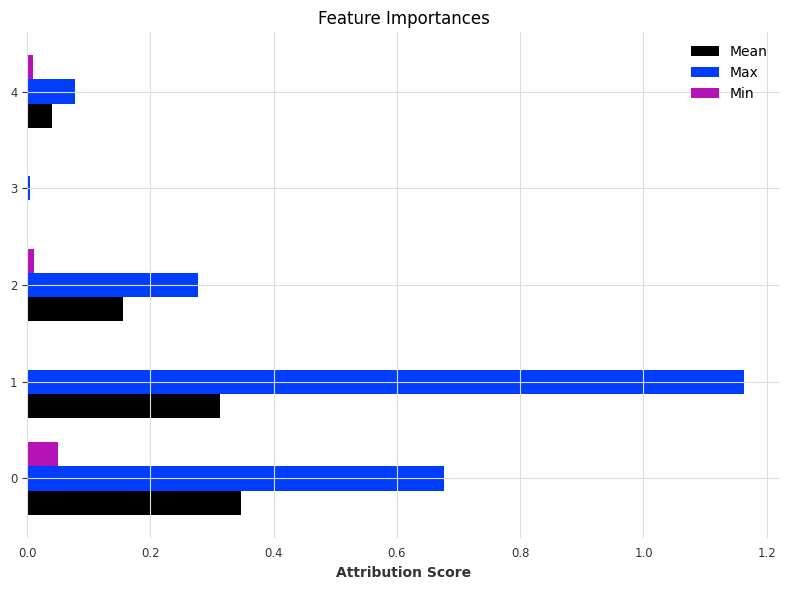

In [4]:
plot_2d_attributions(attr)


## ETTH1

In [5]:
series = ETTh1Dataset().load()

print(series.start_time())
print(series.end_time())

# series.plot()

2016-07-01 00:00:00
2018-06-26 19:00:00


In [6]:
train_series, test_series = series.split_before(0.6)
val_series, test_series = test_series.split_before(0.5)


In [7]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets, T, window_stride=1, pred_len=1):
        self.data = data
        self.targets = targets
        assert targets.size(0) == data.size(0)
        self.T = T # time window
        self.window_stride = window_stride
        self.pred_len = pred_len
        self.N, self.V = data.shape

    def __len__(self):
        return len(range(0, self.N - self.T - self.pred_len + 1, self.window_stride))

    def __getitem__(self, idx):
        start = idx * self.window_stride
        end = start + self.T

        X = self.data[start:end]
        # if mode == "S": # predict only target
        y = self.targets[end:end + self.pred_len].flatten()
        # elif mode == "MS": # predict all variables
        #   y = self.data[end:end + self.pred_len, :7].flatten()
        return X, y


In [8]:
def preprocess_data(series, seq_len, window_stride=1, pred_len=1, batch_size = 512):
    scaler = StandardScaler()
    
    train, test = series.split_before(0.6)
    val, test = test.split_before(0.5)
    
    print("Train/Val/Test", len(train), len(val), len(test))
    
    train_og = train.pd_dataframe()
    train = scaler.fit_transform(train_og)
    train = pd.DataFrame(train, columns=train_og.columns)
    X_train = train
    y_train = train[["OT"]]
    X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
    
    indicators = torch.isfinite(X_train)
    X_train = torch.cat([X_train, indicators], axis=1)
    
    train_dataset = TimeSeriesDataset(X_train, y_train, seq_len, window_stride, pred_len)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False, num_workers=4, pin_memory=True)

    val_og = val.pd_dataframe()
    val = scaler.transform(val_og)
    val = pd.DataFrame(val, columns=val_og.columns)
    X_val = val
    y_val = val[["OT"]]
    X_val = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
    y_val = torch.tensor(y_val.to_numpy(), dtype=torch.float32)
    
    indicators = torch.isfinite(X_val)
    X_val = torch.cat([X_val, indicators], axis=1)
    
    val_dataset = TimeSeriesDataset(X_val, y_val, seq_len, window_stride, pred_len)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False, num_workers=4, pin_memory=True)

    test_og = test.pd_dataframe()
    test = scaler.transform(test_og)
    test = pd.DataFrame(test, columns=test_og.columns)
    X_test = test
    y_test = test[["OT"]]
    X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
    y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)
    
    indicators = torch.isfinite(X_test)
    X_test = torch.cat([X_test, indicators], axis=1)
    
    test_dataset = TimeSeriesDataset(X_test, y_test, seq_len, window_stride, pred_len)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    return train_loader, val_loader, test_loader, scaler


In [9]:
seq_len = 10
train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=24)

for X,y in train_loader:
    print(X.shape)
    print(y.shape)
    break

print("Batches", len(train_loader), len(val_loader), len(test_loader))

Train/Val/Test 10451 3484 3485


torch.Size([512, 10, 14])
torch.Size([512, 24])
Batches 21 7 7


In [10]:
# plots
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, color="black", label="Train")
    plt.plot(val_losses, color="green", label="Val")
    plt.legend()
    plt.show()

def plot_mae_mse(history, title, dec="{:.3g}"):
    xticks = range(len(history[:, 0]))
    plt.plot(xticks, history[:, 2], label='MAE')
    plt.plot(xticks, history[:, 3], label='MSE')

    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    # plt.ylim(0, 1)
    xtick_labels = list(map(int, history[:, 0]))
    plt.xticks(xticks, xtick_labels)
    plt.yscale('log')

    if dec:
        for x,_y in zip(xticks, history[:, 2]):
            label = dec.format(_y)
            plt.annotate(label, # this is the text
                        (x,_y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(0,-10), # distance from text to points (x,y)
                        ha='center') # horizontal alignment can be left, right or center
            
        for x,_y in zip(xticks, history[:, 3]):
            label = dec.format(_y)
            plt.annotate(label, # this is the text
                        (x,_y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(0,-10), # distance from text to points (x,y)
                        ha='center') # horizontal alignment can be left, right or center

    plt.title(title)
    plt.legend()
    plt.show()


def plot_atomics_concepts_metric(history, title, dec="{:.3g}"):
        
    df = pd.DataFrame(history, columns=["n_atomics", "n_concepts", "val_loss", "mae", "mse"])
    mean_atomics = df.groupby("n_atomics").mean()
    mean_concepts = df.groupby("n_concepts").mean()

    # display(mean_atomics)
    plt.plot(mean_atomics.index, mean_atomics["mae"], label='MAE')
    plt.plot(mean_atomics.index, mean_atomics["mse"], label='MSE')
    plt.xlabel('Num Atomics')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over atomics")
    plt.suptitle(title)
    plt.legend()
    plt.show()

    # display(mean_concepts)
    plt.plot(mean_concepts.index, mean_concepts["mae"], label='MAE')
    plt.plot(mean_concepts.index, mean_concepts["mse"], label='MSE')
    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over concepts")
    plt.suptitle(title)
    plt.legend()
    plt.show()
    

def plot_prediction_vs_true(yb, preds, title):
    plt.plot(yb, color="black", label="True")
    plt.plot(preds, color="red", label="Pred")
    plt.title(title)
    plt.legend()
    plt.show()


In [11]:
def initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim, top_k=''):
    model = models.CBM(input_dim = input_dim, 
                            changing_dim = changing_dim, 
                            seq_len = seq_len,
                            num_concepts = n_concepts,
                            opt_lr = 3e-3, # 2e-4
                            opt_weight_decay = 1e-05,
                            l1_lambda=0.001,
                            cos_sim_lambda=0.01,
                            output_dim = output_dim,
                            top_k=top_k,
                            task_type=models.TaskType.REGRESSION,
                            )
    model = model.to(device)
    return model

def initializeModel_with_atomics(n_atomics, n_concepts, input_dim, changing_dim, seq_len, output_dim, use_summaries_for_atomics, top_k=''):
    model = models_3d_atomics_on_variate_to_concepts.CBM(input_dim = input_dim, 
                            changing_dim = changing_dim, 
                            seq_len = seq_len,
                            num_concepts = n_concepts,
                            num_atomics = n_atomics,
                            use_summaries_for_atomics = use_summaries_for_atomics,
                            opt_lr = 3e-3, # 2e-4
                            opt_weight_decay = 1e-05,
                            l1_lambda=0.001,
                            cos_sim_lambda=0.01,
                            output_dim = output_dim,
                            top_k=top_k,
                            task_type=models_3d_atomics_on_variate_to_concepts.TaskType.REGRESSION,
                            )
    model = model.to(device)
    return model

In [12]:
random_seed = 1
set_seed(random_seed)


In [13]:
seq_len = 336
pred_len = 96
n_atomics_list = list(range(2,11,2))
n_concepts_list = list(range(2,11,2))
changing_dim = len(series.columns)
input_dim = 2 * changing_dim


## Original

In [14]:
experiment_folder = f"/workdir/optimal-summaries-public/_models/etth1/multi2single-L{seq_len}-T{pred_len}/"
model_path_og = experiment_folder + "forecasting_c{}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [25]:
history_og = []
attribution = []

train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)

n_concepts = 4
# for n_concepts in n_concepts_list:
print("n_concepts", n_concepts)

model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)
model.fit(train_loader, val_loader, None, save_model_path=model_path_og.format(n_concepts), max_epochs=10000)

display(model)

feature_permutation = FeaturePermutation(model)

model.eval()
with torch.inference_mode():
    for (Xb, yb) in tqdm.tqdm(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model.forward(Xb)
        
        attr = torch.zeros_like(Xb, device=device)
        for i, target in enumerate(np.arange(pred_len, step=5)):
            attr += feature_permutation.attribute(Xb, target=torch.tensor(target))
        attr /= (i+1)
        attribution.append(attr.cpu())
        
    #     mae = mae_metric(preds, yb).item()
    #     mse = mse_metric(preds, yb).item()
    # mae = mae_metric.compute().item()
    # mse = mse_metric.compute().item()
    # mae_metric.reset()
    # mse_metric.reset()

# history = [n_concepts, round(model.val_losses[-1],2), mae, mse]
# display(history)
# history_og.append(np.array(history))

# plot_losses(model.train_losses, model.val_losses)
    
# history_og = np.array(history_og)
# history_og.shape


Train/Val/Test 10451 3484 3485
n_concepts 4
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/multi2single-L336-T96/forecasting_c4.pt


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


CBM(
  (sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=4788, out_features=4, bias=True)
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

100%|██████████| 6/6 [30:13<00:00, 302.25s/it]


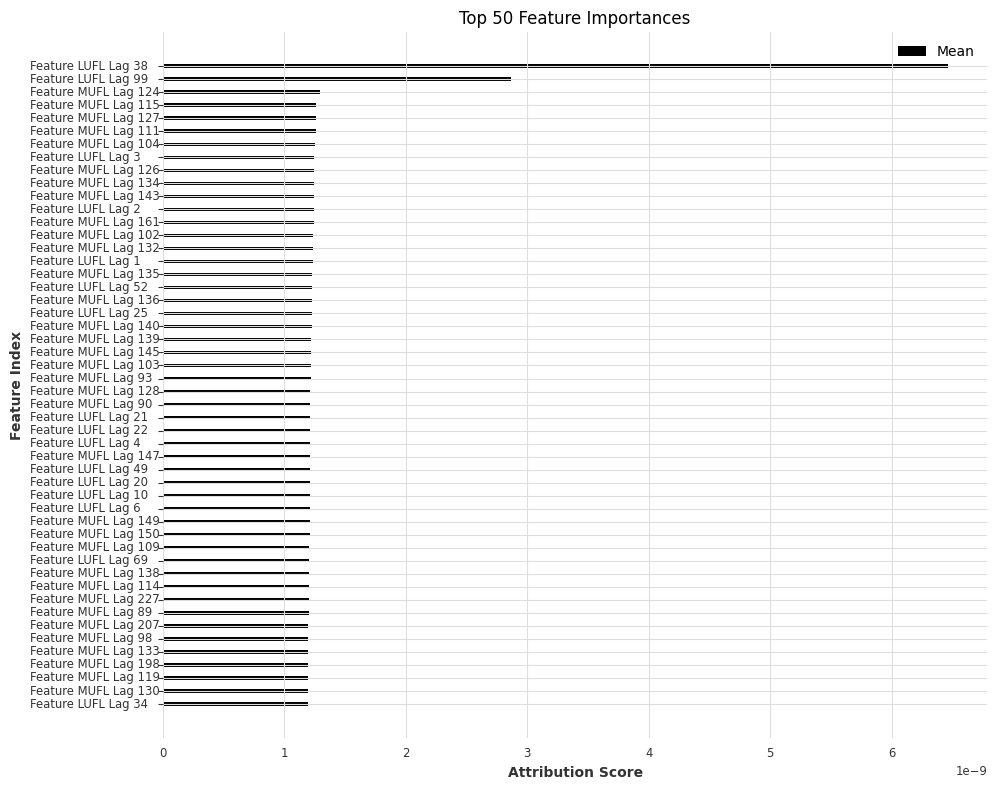

In [24]:
attr = torch.cat(attribution)
plot_3d_attributions(attr, series.pd_dataframe().columns, topk=50)


In [ ]:
plot_mae_mse(history_og, "Original")


In [ ]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)
n_concepts = 10

model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)
model.fit(train_loader, val_loader, None, save_model_path=model_path_og.format(n_concepts), max_epochs=10000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(val_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model.forward(Xb)
        
        mae = mae_metric(preds, yb).item()
        mse = mse_metric(preds, yb).item()
        break
    mae = mae_metric.compute().item()
    mse = mse_metric.compute().item()
    mae_metric.reset()
    mse_metric.reset()


i = 20
yb = yb.cpu().numpy()[i]
preds = preds.cpu().numpy()[i]

print(yb.shape)
print(preds.shape)

plot_prediction_vs_true(yb, preds, title=f"Original - Predictions with {n_concepts} Concepts")


## Summaries cat Atomics

In [ ]:
experiment_folder = f"/workdir/optimal-summaries-public/_models/etth1/summaries-cat-atomics-L{seq_len}-T{pred_len}/"
model_path_re = experiment_folder + "forecasting_c{}_a{}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [ ]:
history_re = []

train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)

for n_concepts in n_concepts_list:
    for n_atomics in n_atomics_list:
        print("n_atomics", n_atomics, "n_concepts", n_concepts)
        
        model = initializeModel_with_atomics(n_atomics, n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len, use_summaries_for_atomics=False)
        model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format(n_concepts, n_atomics), max_epochs=10000)
        
        print("Trained for ", model.curr_epoch+1)
        display(model)
        
        model.eval()
        with torch.no_grad():
            for batch_idx, (Xb, yb) in enumerate(test_loader):
                Xb, yb = Xb.to(device), yb.to(device)
                preds = model.forward(Xb)
                
                mae = mae_metric(preds, yb).item()
                mse = mse_metric(preds, yb).item()
            mae = mae_metric.compute().item()
            mse = mse_metric.compute().item()
            mae_metric.reset()
            mse_metric.reset()
        
        history = [n_atomics, n_concepts, round(model.val_losses[-1],2), mae, mse]
        display(history)
        history_re.append(np.array(history))
    
        plot_losses(model.train_losses, model.val_losses)
        
        del model
        gc.collect()
        torch.cuda.empty_cache()
    
history_re = np.array(history_re)
history_re.shape


In [ ]:
# plot_mae_mse(history_re, "Summaries cat Atomics")
plot_atomics_concepts_metric(history_re, "Summaries cat Atomics")


In [ ]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)
n_concepts = 600

model = initializeModel_redesigned(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)
model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format(n_concepts), max_epochs=10000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(val_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model.forward(Xb)
        
        mae = mae_metric(preds, yb).item()
        mse = mse_metric(preds, yb).item()
        break
    mae = mae_metric.compute().item()
    mse = mse_metric.compute().item()
    mae_metric.reset()
    mse_metric.reset()


i = 20
yb = yb.cpu().numpy()[i]
preds = preds.cpu().numpy()[i]

print(yb.shape)
print(preds.shape)

plot_prediction_vs_true(yb, preds, title=f"Redesigned - Predictions with {n_concepts} Concepts")


## Input cat Summaries to Atomics

In [ ]:
experiment_folder = f"/workdir/optimal-summaries-public/_models/etth1/input-cat-summaries-L{seq_len}-T{pred_len}/"
model_path_re = experiment_folder + "forecasting_c{}_a{}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [ ]:
history_re = []

train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)

for n_concepts in n_concepts_list:
    for n_atomics in n_atomics_list:
        print("n_atomics", n_atomics, "n_concepts", n_concepts)
        
        model = initializeModel_with_atomics(n_atomics, n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len, use_summaries_for_atomics=True)
        print("test", model.output_dim)
        model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format(n_concepts, n_atomics), max_epochs=10000)
        
        print("Trained for ", model.curr_epoch+1)
        display(model)
        
        model.eval()
        with torch.no_grad():
            for batch_idx, (Xb, yb) in enumerate(test_loader):
                Xb, yb = Xb.to(device), yb.to(device)
                preds = model.forward(Xb)
                
                mae = mae_metric(preds, yb).item()
                mse = mse_metric(preds, yb).item()
            mae = mae_metric.compute().item()
            mse = mse_metric.compute().item()
            mae_metric.reset()
            mse_metric.reset()
        
        history = [n_atomics, n_concepts, round(model.val_losses[-1],2), mae, mse]
        display(history)
        history_re.append(np.array(history))
    
        plot_losses(model.train_losses, model.val_losses)
        torch.cuda.empty_cache()
    
history_re = np.array(history_re)
history_re.shape


In [ ]:
# plot_mae_mse(history_re, "Input cat Summaries")
plot_atomics_concepts_metric(history_re, "Input cat Summaries")


In [ ]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)
n_concepts = 600

model = initializeModel_redesigned(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)
model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format(n_concepts), max_epochs=10000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(val_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model.forward(Xb)
        
        mae = mae_metric(preds, yb).item()
        mse = mse_metric(preds, yb).item()
        break
    mae = mae_metric.compute().item()
    mse = mse_metric.compute().item()
    mae_metric.reset()
    mse_metric.reset()


i = 20
yb = yb.cpu().numpy()[i]
preds = preds.cpu().numpy()[i]

print(yb.shape)
print(preds.shape)

plot_prediction_vs_true(yb, preds, title=f"Redesigned - Predictions with {n_concepts} Concepts")


## Redesigned + LambdaLR as paper

In [ ]:
experiment_folder = f"/workdir/optimal-summaries-public/_models/etth1/time2con-lambdalr-multi2single-L{seq_len}-T{pred_len}/"
model_path_re_lamdalr = experiment_folder + "forecasting_c{}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [ ]:
history_re_lambdalr = []

train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)

for n_concepts in n_concepts_list:
    print("n_concepts", n_concepts)
    
    model = initializeModel_redesigned(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=model.optimizer, patience=5)
    lr_lambda = lambda epoch: 0.5 ** ((epoch - 1) // 1)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=model.optimizer, lr_lambda=lr_lambda)
    model.fit(train_loader, val_loader, None, save_model_path=model_path_re_lamdalr.format(n_concepts), max_epochs=10000, scheduler=scheduler)
    
    display(model)
    
    model.eval()
    with torch.no_grad():
        for batch_idx, (Xb, yb) in enumerate(test_loader):
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model.forward(Xb)
            
            mae = mae_metric(preds, yb).item()
            mse = mse_metric(preds, yb).item()
        mae = mae_metric.compute().item()
        mse = mse_metric.compute().item()
        mae_metric.reset()
        mse_metric.reset()
    
    history = [n_concepts, round(model.val_losses[-1],2), mae, mse]
    display(history)
    history_re_lambdalr.append(np.array(history))
    
    plot_losses(model.train_losses, model.val_losses)
    torch.cuda.empty_cache()
    
history_re_lambdalr = np.array(history_re_lambdalr)
history_re_lambdalr.shape


In [ ]:
plot_mae_mse(history_re_lambdalr, "Redesigned + LambdaLR")


In [ ]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)
n_concepts = 4

model = initializeModel_redesigned(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)
# model.fit(train_loader, val_loader, None, save_model_path=model_path_re_lamdalr.format(n_concepts), max_epochs=10000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(val_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model.forward(Xb)
        
        mae = mae_metric(preds, yb).item()
        mse = mse_metric(preds, yb).item()
        break
    mae = mae_metric.compute().item()
    mse = mse_metric.compute().item()
    mae_metric.reset()
    mse_metric.reset()


i = 20
yb = yb.cpu().numpy()[i]
preds = preds.cpu().numpy()[i]

print(yb.shape)
print(preds.shape)

plot_prediction_vs_true(yb, preds, title=f"Redesigned + LambdaLR - Predictions with {n_concepts} Concepts")


## Redesigned + ReduceLROnPlateau

In [ ]:
experiment_folder = f"/workdir/optimal-summaries-public/_models/etth1/time2con-reduceonplateau-multi2single-L{seq_len}-T{pred_len}/"
model_path_re_reduceonplateau = experiment_folder + "forecasting_c{}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [ ]:
history_re_reduceonplateau = []

train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)

for n_concepts in n_concepts_list:
    print("n_concepts", n_concepts)
    
    model = initializeModel_redesigned(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=model.optimizer, patience=5) # half patience of early stopping
    model.fit(train_loader, val_loader, None, save_model_path=model_path_re_reduceonplateau.format(n_concepts), max_epochs=10000, scheduler=scheduler)
    
    display(model)
    
    model.eval()
    with torch.no_grad():
        for batch_idx, (Xb, yb) in enumerate(test_loader):
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model.forward(Xb)
            
            mae = mae_metric(preds, yb).item()
            mse = mse_metric(preds, yb).item()
        mae = mae_metric.compute().item()
        mse = mse_metric.compute().item()
        mae_metric.reset()
        mse_metric.reset()
    
    history = [n_concepts, round(model.val_losses[-1],2), mae, mse]
    display(history)
    history_re_reduceonplateau.append(np.array(history))
    
    plot_losses(model.train_losses, model.val_losses)
    torch.cuda.empty_cache()
    
history_re_reduceonplateau = np.array(history_re_reduceonplateau)
history_re_reduceonplateau.shape


In [ ]:
plot_mae_mse(history_re_reduceonplateau, "Redesigned + ReduceLROnPlateau")


In [ ]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)
n_concepts = 10

model = initializeModel_redesigned(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)
# model.fit(train_loader, val_loader, None, save_model_path=model_path_re_reduceonplateau.format(n_concepts), max_epochs=10000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(val_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model.forward(Xb)
        
        mae = mae_metric(preds, yb).item()
        mse = mse_metric(preds, yb).item()
        break
    mae = mae_metric.compute().item()
    mse = mse_metric.compute().item()
    mae_metric.reset()
    mse_metric.reset()


i = 20
yb = yb.cpu().numpy()[i]
preds = preds.cpu().numpy()[i]

print(yb.shape)
print(preds.shape)

plot_prediction_vs_true(yb, preds, title=f"Redesigned + ReduceLROnPlateau - Predictions with {n_concepts} Concepts")


## Optimization

In [ ]:
# feature weights
n_concepts = 5

model = initializeModel(n_concepts, input_dim, changing_dim, seq_len)
model.fit(train_loader, val_loader, None, model_path.format(n_concepts), 1000)

for name, param in model.named_parameters():
    if "bottleneck.weight" in name:
        bottleneck_weights = param
feature_weights = bottleneck_weights.cpu().detach().numpy()

feature_weights.shape

In [ ]:
# visualize weight magnitudes
for c in range(n_concepts):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    inds = np.argsort(-np.abs(feature_weights[c]))[:100]
    ax.bar(np.arange(1,101),np.abs(feature_weights[c])[inds])
    ax.set_xlabel("Top 100 features")
    ax.set_ylabel("abs value of feature coefficient")
    plt.show()


In [ ]:
# get 90th percentile of feature weights
sum90p = np.sum(np.abs(feature_weights), axis=-1)*0.90
sum90p.shape


In [ ]:
# get top K indizes
top_k_inds = []
for c in range(n_concepts):
    topkinds_conc = []
    curr_sum = 0
    inds = np.argsort(-np.abs(feature_weights[c])) #desc
    sorted_weights = feature_weights[c][inds]
    
    for ind, weight in zip(inds, sorted_weights):
        curr_sum += abs(weight)
        if curr_sum <= sum90p[c]:
            topkinds_conc.append(ind)
        else:
            break
    
    # if selects less than 10, choose 10 best
    if len(topkinds_conc) < 10:
        topkinds_conc = np.argsort(-np.abs(feature_weights[c]))[:10].tolist()
    
    top_k_inds.append(topkinds_conc)

top_k_inds

In [ ]:
# write top k inds to csv
filename = experiment_folder + "top-k/top_k_inds_c{}.csv".format(n_concepts)

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    # writing the data rows 
    csvwriter.writerows(top_k_inds)


In [ ]:
best_aucs, best_auc_inds, best_auc_concepts = greedy_selection(auroc_metric, test_loader, top_k_inds, model)


In [ ]:
filename = experiment_folder + "top-k/bottleneck_r{}_c{}_topkinds.csv".format(random_seed, n_concepts)

# writing to csv file
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(["Best AUC", "Best AUC Concept #", "Best AUC ind #"])
    # writing the data rows 
    for row in zip(best_aucs, best_auc_concepts, best_auc_inds):
        csvwriter.writerow(list(row))


## Multi-class

In [ ]:
experiment_folder = "/workdir/optimal-summaries-public/_models/arabic/multiclass/"
model_path = experiment_folder + "arabic_c{}.pt"
random_seed = 1

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [ ]:
history_multiclass = []

set_seed(random_seed)

data, y_ohe, num_classes, weights = preprocess_data_multiclass(X, y)
train_loader, val_loader, test_loader = initialize_data(1, data, y_ohe, multiclass=True)

input_dim = data.shape[2]
changing_dim = X[0].shape[0]
seq_len = data.shape[1]

auroc_metric = AUROC(task="multiclass", num_classes=num_classes).to(device)
accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)

for n_concepts in range(1,16):
    print(n_concepts)
    
    model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, num_classes)
    model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)
    
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model(Xb)
        
        auc = auroc_metric(probs, yb).item()
        acc = accuracy_metric(probs, yb).item()
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()
    
    history = [n_concepts, model.val_losses[-1], auc, acc]
    history_multiclass.append(np.array(history))
history_multiclass = np.array(history_multiclass)
history_multiclass.shape


In [ ]:
# plot
plt.plot(history_multiclass[:, 0], history_multiclass[:, 2], label='AUC')
plt.plot(history_multiclass[:, 0], history_multiclass[:, 3], label='ACC')

plt.xlabel('Num Concepts')
plt.ylabel('Criteria')
plt.title('Plot of Concepts vs Criteria')
plt.xticks(np.arange(min(history_multiclass[:, 0]), max(history_multiclass[:, 0])+1, 1))

for x,_y in zip(history_multiclass[:, 0], history_multiclass[:, 2]):
    label = "{:.2f}".format(_y)
    plt.annotate(label, # this is the text
                 (x,_y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for x,_y in zip(history_multiclass[:, 0], history_multiclass[:, 3]):
    label = "{:.2f}".format(_y)
    plt.annotate(label, # this is the text
                 (x,_y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.legend()
plt.show()


In [ ]:
# feature weights
n_concepts = 5

model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, num_classes)
model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)

for name, param in model.named_parameters():
    if "bottleneck.weight" in name:
        bottleneck_weights = param
feature_weights = bottleneck_weights.cpu().detach().numpy()

feature_weights.shape

In [ ]:
# visualize weight magnitudes
for c in range(n_concepts):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    inds = np.argsort(-np.abs(feature_weights[c]))[:100]
    ax.bar(np.arange(1,101),np.abs(feature_weights[c])[inds])
    ax.set_xlabel("Top 100 features")
    ax.set_ylabel("abs value of feature coefficient")
    plt.show()


In [ ]:
# get 90th percentile of feature weights
sum90p = np.sum(np.abs(feature_weights), axis=-1)*0.90
sum90p.shape


In [ ]:
# get top K indizes
top_k_inds = []
for c in range(n_concepts):
    topkinds_conc = []
    curr_sum = 0
    inds = np.argsort(-np.abs(feature_weights[c])) #desc
    sorted_weights = feature_weights[c][inds]
    
    for ind, weight in zip(inds, sorted_weights):
        curr_sum += abs(weight)
        if curr_sum <= sum90p[c]:
            topkinds_conc.append(ind)
        else:
            break
    
    # if selects less than 10, choose 10 best
    if len(topkinds_conc) < 10:
        topkinds_conc = np.argsort(-np.abs(feature_weights[c]))[:10].tolist()
    
    top_k_inds.append(topkinds_conc)

top_k_inds

In [ ]:
# write top k inds to csv
filename = experiment_folder + "top-k/top_k_inds_c{}.csv".format(n_concepts)

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    # writing the data rows 
    csvwriter.writerows(top_k_inds)


In [ ]:
data_cols = [i for i in range(1,14)] + [str(i) + "_ind" for i in range(1,14)]

for c, _list in enumerate(top_k_inds):
    for ind in _list:
        name, summary = getConcept(data_cols, input_dim, changing_dim, int(ind))
        print(f"Concept {c}: ID {ind}, Feature {name}, Summary {summary}")


In [ ]:
greedy_results = greedy_selection(auroc_metric, test_loader, top_k_inds, model, track_metrics={"acc": accuracy_metric})
greedy_results.head()

In [ ]:
top_k_csv_file = experiment_folder + "top-k/bottleneck_r{}_c{}_topkinds.csv".format(random_seed, n_concepts)

# writing to csv file
with open(top_k_csv_file, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(greedy_results.columns)
    # writing the data rows 
    for row in greedy_results.itertuples(index=False):
        csvwriter.writerow(list(row))


In [ ]:
data_cols = [i for i in range(1,14)] + [str(i) + "_ind" for i in range(1,14)]

sorted_ = greedy_results.sort_values(["Concept", "ID"])

for row in sorted_.itertuples(index=False):
    name, summary = getConcept(data_cols, input_dim, changing_dim, row[1])
    print(f"Concept {row[2]}: ID {row[1]}, Feature {name}, Summary {summary}")

In [ ]:
plt.plot(greedy_results["Score"])
plt.plot(greedy_results["acc"])
plt.show()

In [ ]:
top_k_csv_file = "/workdir/optimal-summaries-public/_models/arabic/multiclass/top-k/bottleneck_r1_c6_topkinds.csv"
n_concepts = 6
model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, num_classes, top_k=top_k_csv_file)
# model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model(Xb)
        
        auc = auroc_metric(probs, yb).item()
        acc = accuracy_metric(probs, yb).item()
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()

print(auc)
print(acc)


In [ ]:
model.fit(train_loader, val_loader, weights, save_model_path="/workdir/optimal-summaries-public/_models/arabic/multiclass/top-k/arabic_c6_finetuned.pt", epochs=3000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model(Xb)
        
        auc = auroc_metric(probs, yb)
        acc = accuracy_metric(probs, yb)
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()
    
print(auc)
print(acc)
